In [3]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import importlib

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

from tqdm import tqdm
import io, sys
from contextlib import redirect_stdout, redirect_stderr

import os

import h5py
import hdf5plugin

import sys
sys.path.append('./XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA/'
masks_folder = '../masks/'
fit_outs_folder = './data/fit_outs/'
Idts_folder = './data/Idts/'
g2_folder = './data/g2/'

# EXPERIMENTAL VARIABLES
XPCS.set_expvar(1350, 1400, 7)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

## Load masks

In [4]:
e4m_htmask = np.load(masks_folder+'e4m_htmask_copper_foil_30um_1_1'+'.npy')
e4m_mask = np.load(masks_folder+'e4m_mask'+'.npy')
#bs_mask = np.load(masks_folder+'bs_mask_copper_foil_30um'+'.npy')  # beam-stop mask

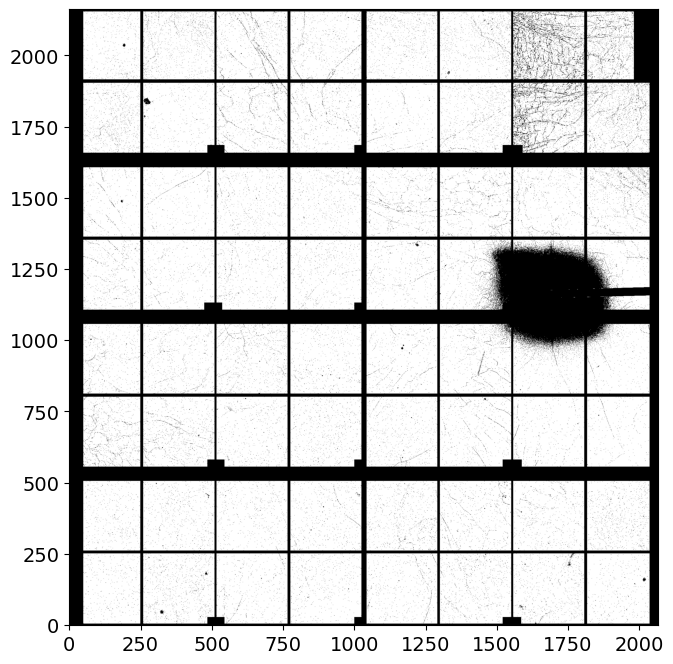

In [5]:
plt.figure(figsize=(8, 8))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')

### BS mask and Q definition
Using a random scan in GeO2_6, because we are not changing the measurement configuration

#### Beamstop mask

In [6]:
#######################################
sample_name = 'GeO2_6'
Ndataset = 1
Nscan =12
Nfi, Nff = 0, 1000
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

#############################
command = mtimescan 0.02 1 220000
Ei = 9.699998837562536
itime = 0.0201
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/1 loops)
Done!
Concatenating vectors ...
Done!
	 | Sparse array loaded from ../RAW_DATA/GeO2_6/GeO2_6_0001/scan0012/
	 | Shape:       (1000, 4471016)
	 | Sparsity:     3.8e-03
	 | Memory usage (scipy.csr_array): 0.192 GB (np.array usage: 16.656 GB)


################################################################################
Maximum count in the hull run -> 4689
# of pixels above Ith_high treshold ->  75 pixels (of 4471016 => 0.0 %)
################################################################################



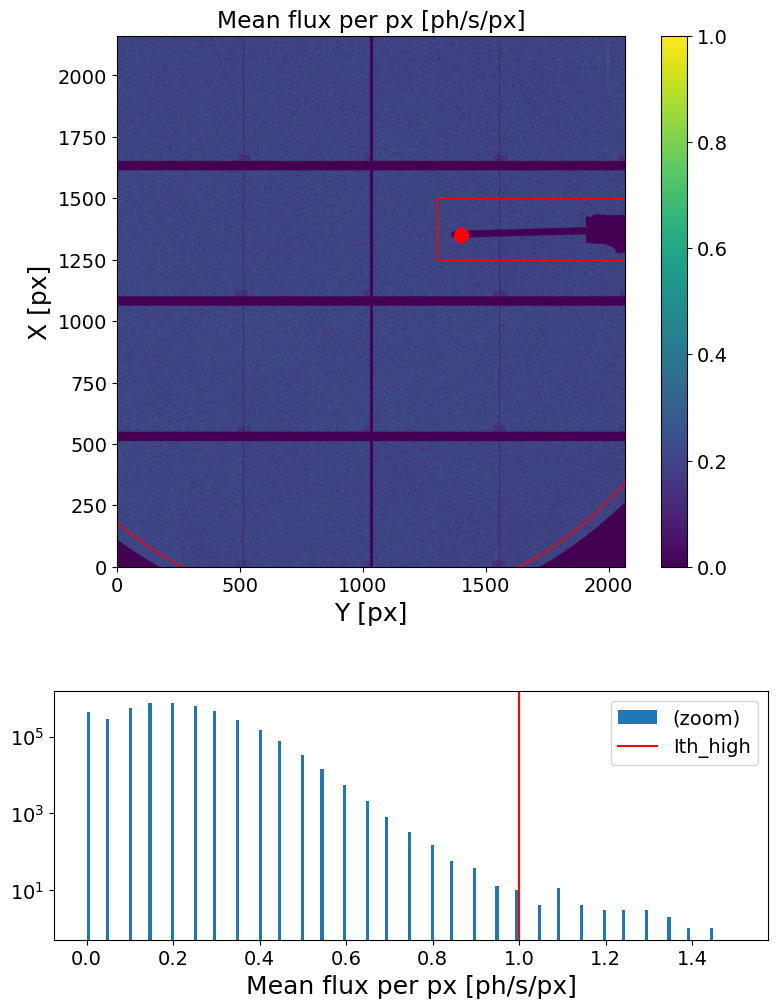

In [7]:
geom = [{'geom':'Rectangle', 'x0':1250, 'y0':1300, 'xl':250, 'yl':1950, 'inside':False},
        {'geom':'Circle', 'Cx':1300, 'Cy':950, 'r':1470, 'inside':True}, 
        ]
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nff=10000, mask_geom=geom,)

#################################################
Masked area =  93.74594052000708 %
#################################################



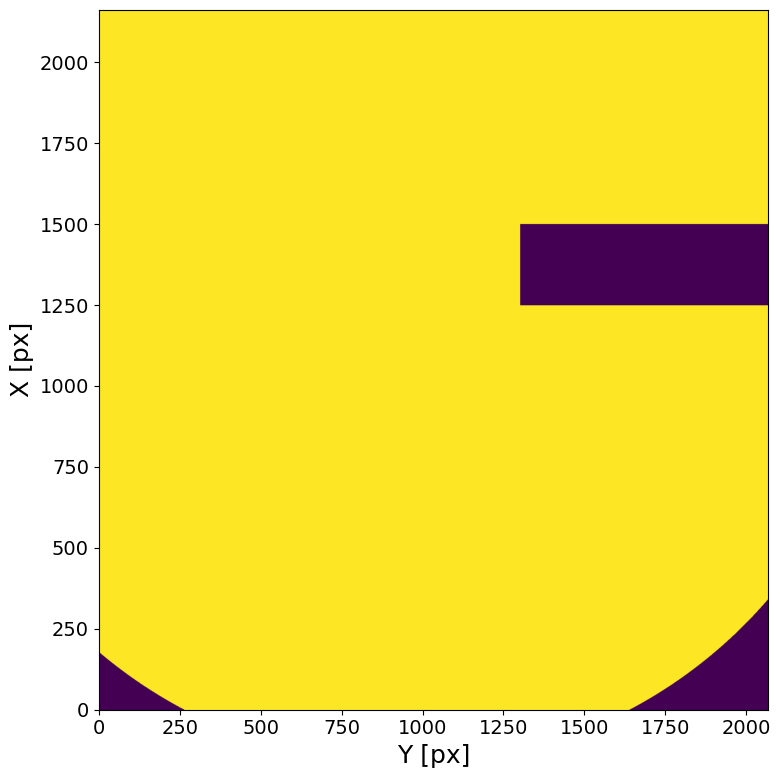

In [8]:
bs_mask = XPCS.gen_mask(e4m_data, itime, e4m_mask=None, mask_geom=geom)

#### Q mask

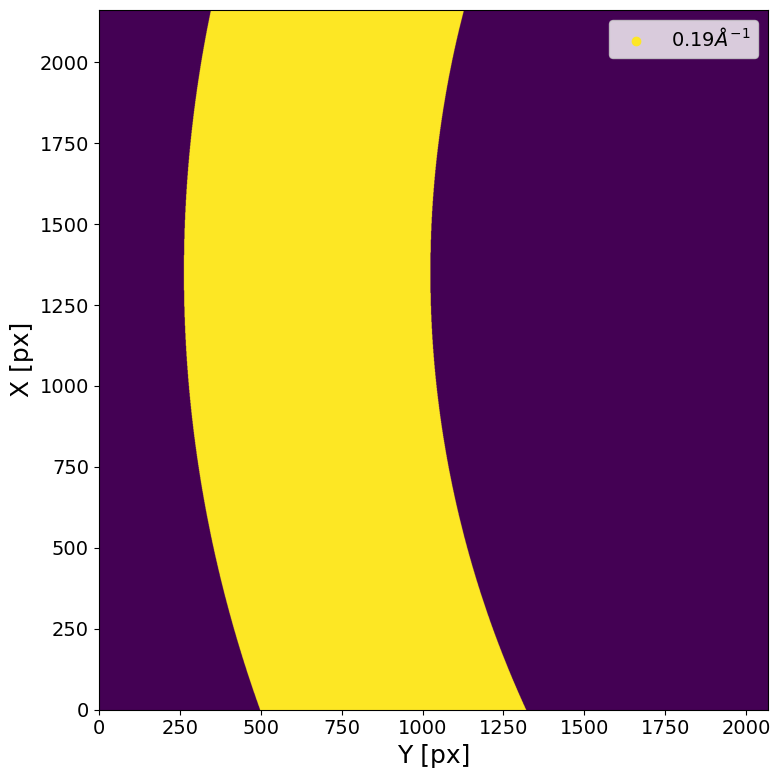

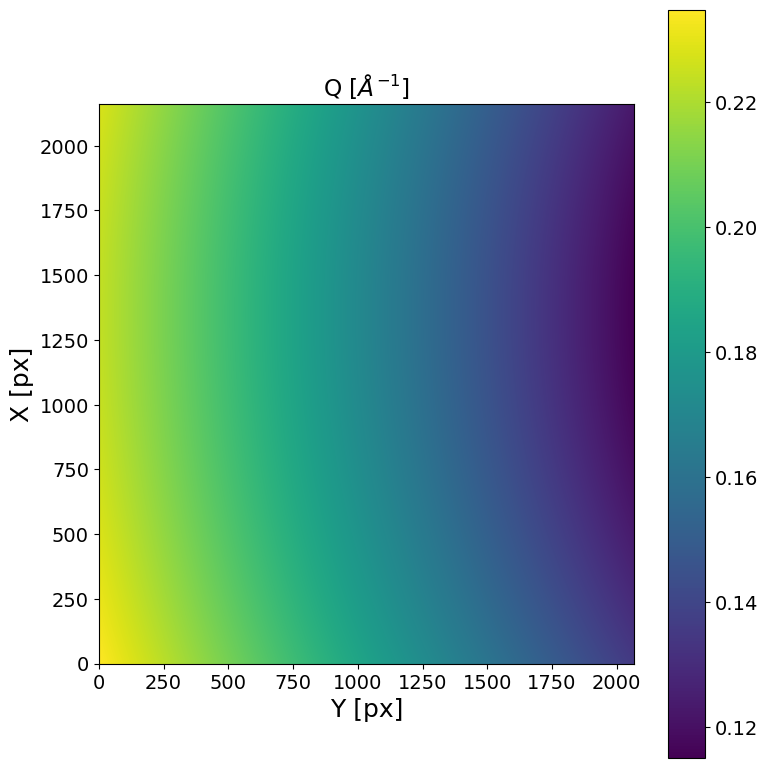

In [9]:
Qmask = XPCS.gen_Qmask(Ei, theta, .19, .02, Qmap_plot=True)

## XPCS scan (T = 30C Q =  0.19 Å, 20 min @ 1ms (1_200_000 fm)) (GeO2_4_30C, dataset 2, scan 3, 9.7 keV)

In [9]:
#######################################
sample_name = 'GeO2_4_30C'
Ndataset = 2
Nscan = 4
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1200192
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/241 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  135 pixels (of 4471016 => 0.0 %)
################################################################################



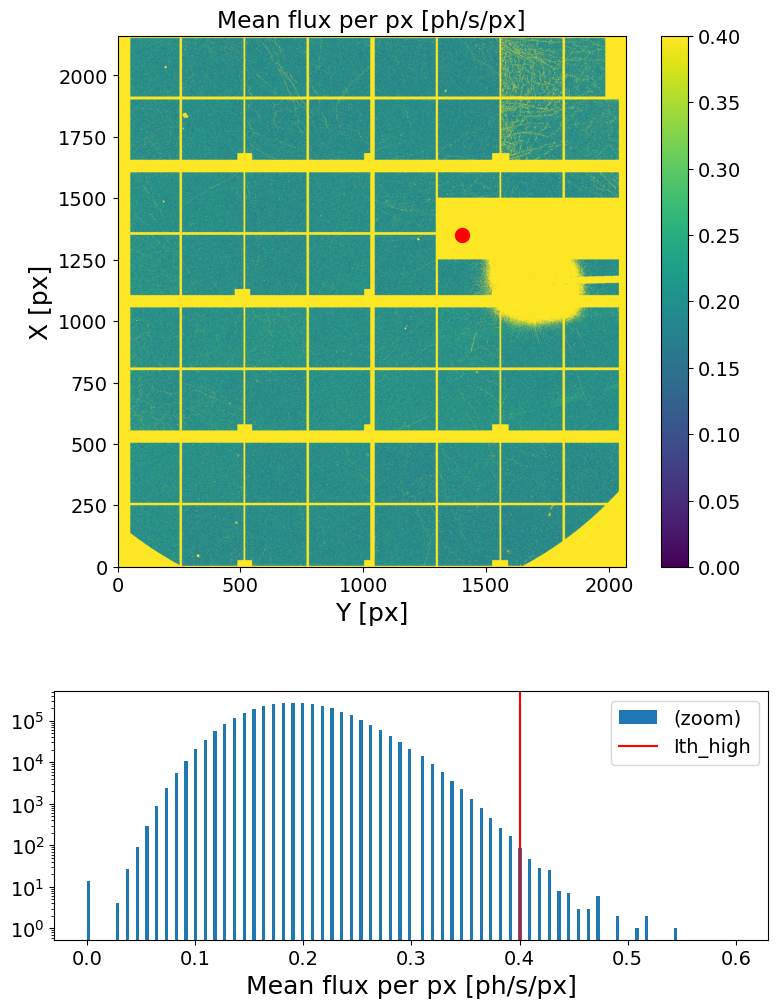

In [10]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [11]:
####################
Lbin = 1
Nstep = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

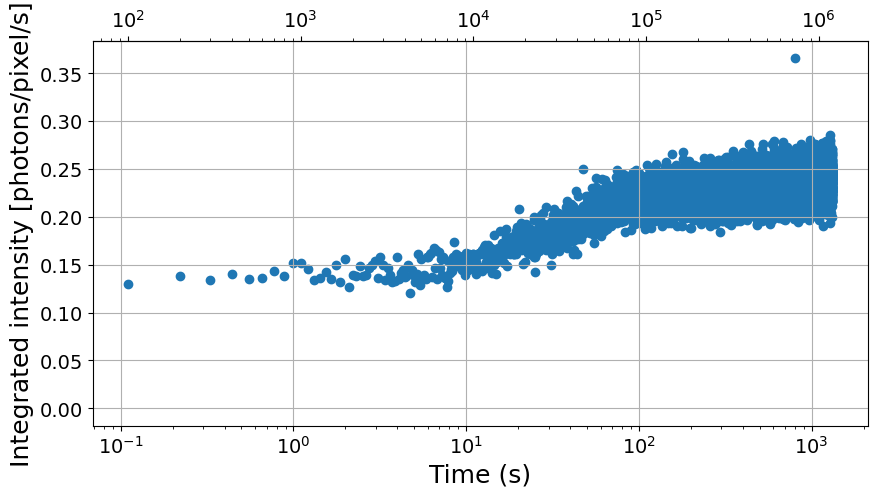

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [13]:
###################
Nfi = 100_000
Nff = None
Lbin = 10
Nbunch = 5
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 100000 , Nff = 320038 ) ...
Loading frames ...
Done! (elapsed time = 4.77 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 6.72 s)
	 | 22003 frames X 4471016 pixels
	 | sparsity = 2.29e-03
	 | memory usage (sparse.csr_array @ float64) = 2.513 GB
Masking data ...
Done! (elapsed time = 2.81 s)
	 | 22003 frames X 1424709 pixels
	 | sparsity = 2.48e-03
	 | memory usage (sparse.csr_array @ float64) = 0.87 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 5.69 s)
	 | 22003 X 22003 squared matrix
	 | memory usage (np.array @ float64) = 3.607 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 1.42 s)

Done!

Computing G2t for bunch 2 (Nfi = 320038 , Nff = 540076 ) ...
Loading frames ...
Done! (elapsed time = 3.81 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 6.47 s)
	 | 22003 frames X 4471016 pixels
	 | sparsity = 2.34e-03
	 | memory usage (sparse.csr_array @ float64) = 2.571 GB

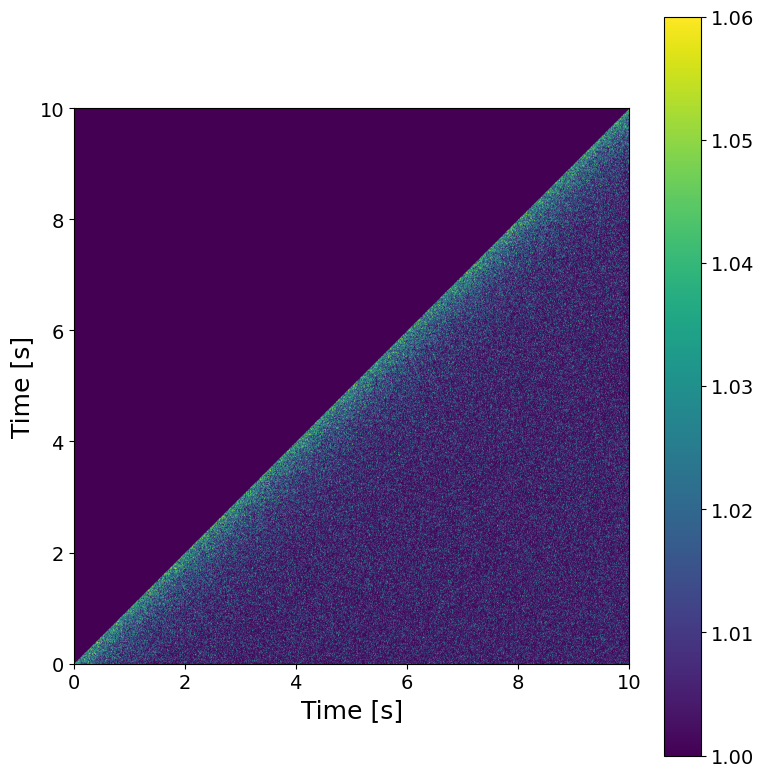

In [14]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

In [15]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.57 s)



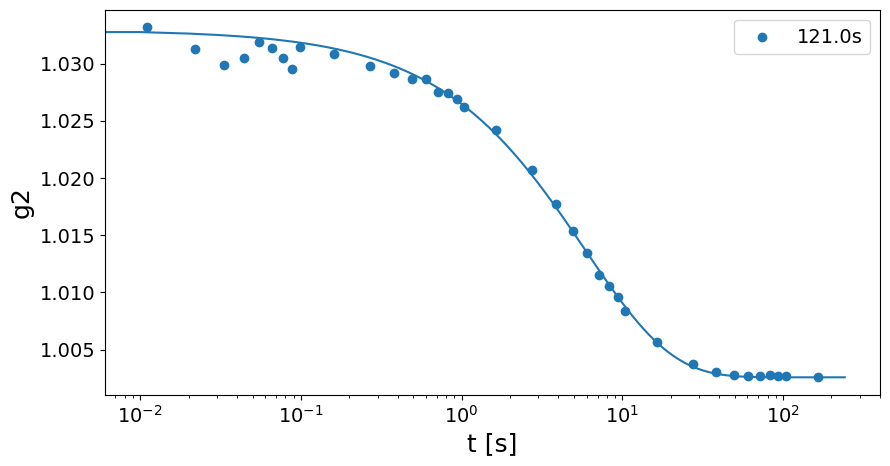

tau = 5.850003891843158 +/- 0.18183009075263418
beta = 0.8083777471893149 +/- 0.020664917566224877
c = 0.030355579202803427 +/- 0.0005741208212575034
y0 = 1.0025770556758344 +/- 2.5200645878821166e-05


In [16]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

## XPCS scan (T = 30C Q =  0.19 Å, 20 min @ 1ms (1_200_000 fm)) (GeO2_4_30C, dataset 2, scan 5, E = 9.7 keV)

In [17]:
#######################################
sample_name = 'GeO2_4_30C'
Ndataset = 2
Nscan = 5
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 2400384
Ei = 9.699998837562536
itime = 0.0011
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/481 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/481 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  1 pixels (of 4471016 => 0.0 %)
################################################################################



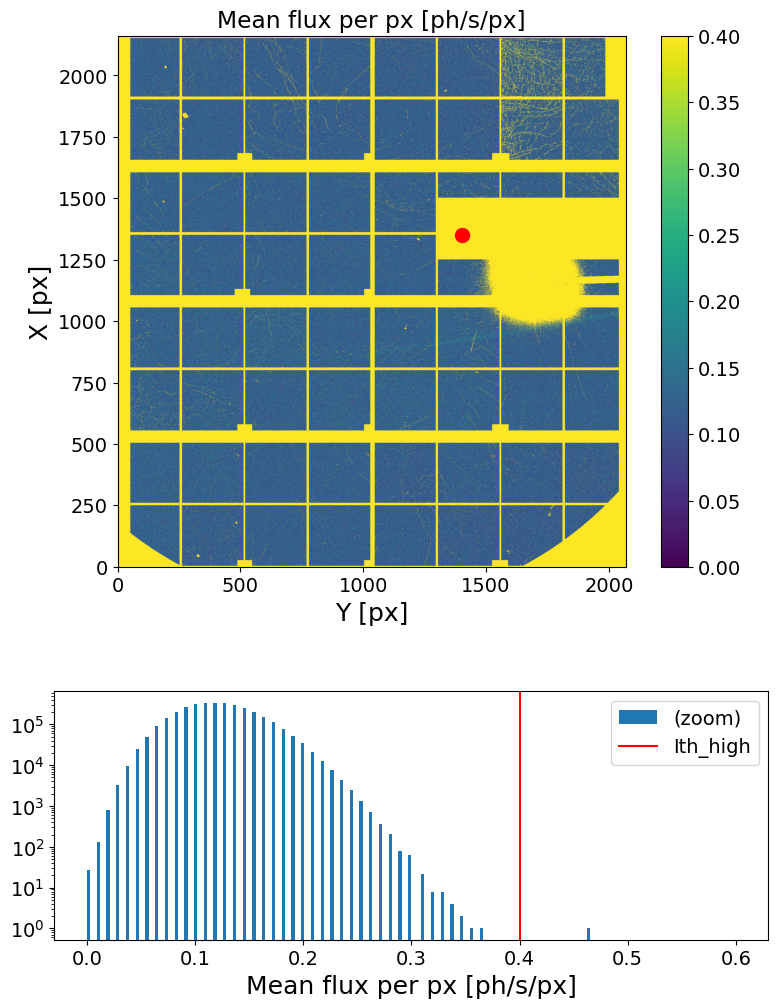

In [18]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [19]:
####################
Lbin = 1
Nstep = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

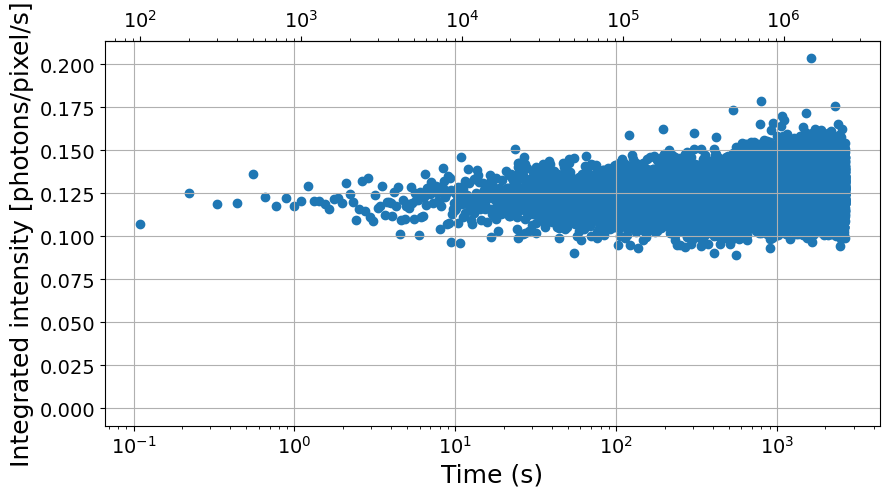

: 

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [ ]:
###################
Nfi = 100_000
Nff = None
Lbin = 10
Nbunch = 5
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 100000 , Nff = 560076 ) ...
Loading frames ...
Done! (elapsed time = 1.84 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 5.07 s)
	 | 46007 frames X 4471016 pixels
	 | sparsity = 1.24e-03
	 | memory usage (sparse.csr_array @ float64) = 2.857 GB
Masking data ...
Done! (elapsed time = 2.33 s)
	 | 46007 frames X 1424709 pixels
	 | sparsity = 1.35e-03
	 | memory usage (sparse.csr_array @ float64) = 0.99 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 9.4 s)
	 | 46007 X 46007 squared matrix
	 | memory usage (np.array @ float64) = 15.77 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 7.03 s)

Done!

Computing G2t for bunch 2 (Nfi = 560076 , Nff = 1020152 ) ...
Loading frames ...
Done! (elapsed time = 1.93 s)
Binning frames (Lbin = 10, using MKL library) ...


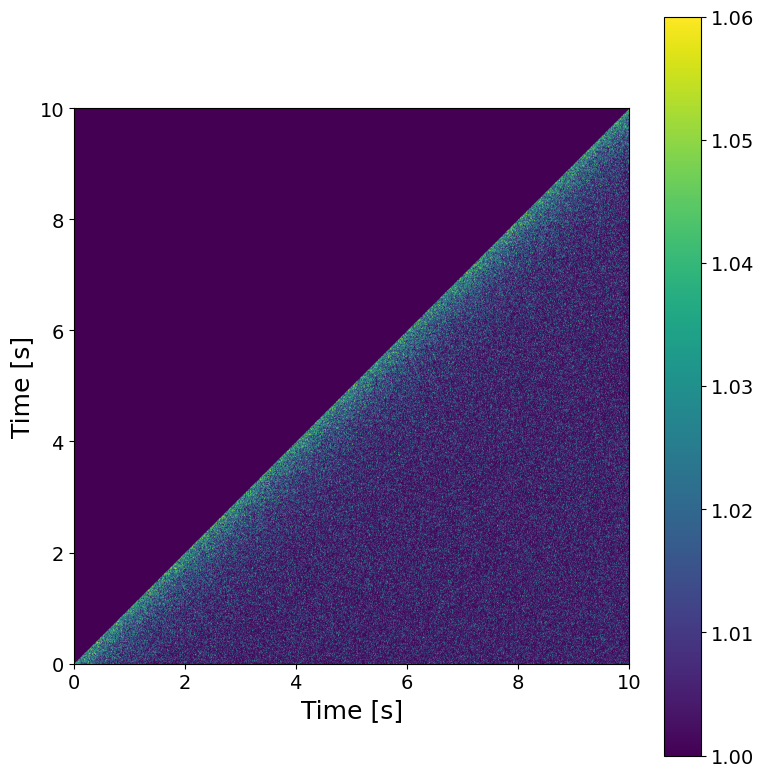

In [ ]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

In [ ]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.57 s)



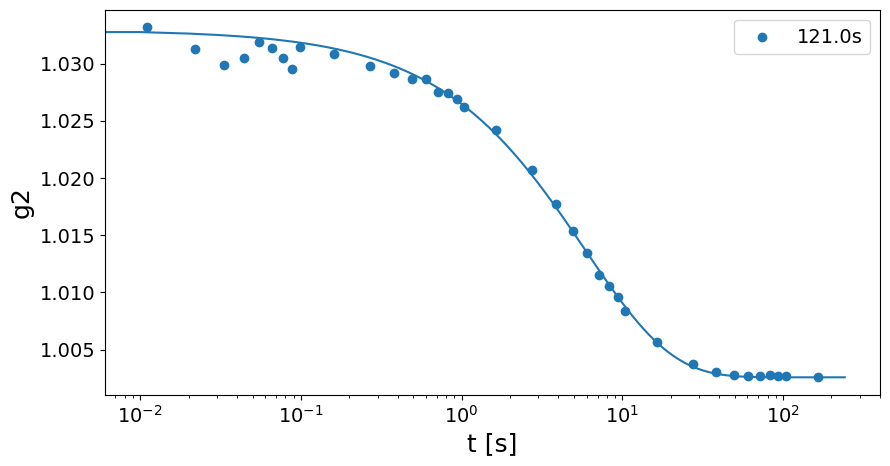

tau = 5.850003891843158 +/- 0.18183009075263418
beta = 0.8083777471893149 +/- 0.020664917566224877
c = 0.030355579202803427 +/- 0.0005741208212575034
y0 = 1.0025770556758344 +/- 2.5200645878821166e-05


In [ ]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

## XPCS scan (T = 30C Q =  0.19 Å, 50 min @ 1ms (3_000_000 fm)) (GeO2_4_30C, dataset 2, scan 5, 10.25 keV)

In [56]:
#######################################
sample_name = 'GeO2_4_10p25'
Ndataset = 1
Nscan = 14
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 10.25000164635837
itime = 0.0011
theta = 1.7500000000000004
Q = 0.16
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/624 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/624 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  2494 pixels (of 4471016 => 0.07 %)
################################################################################



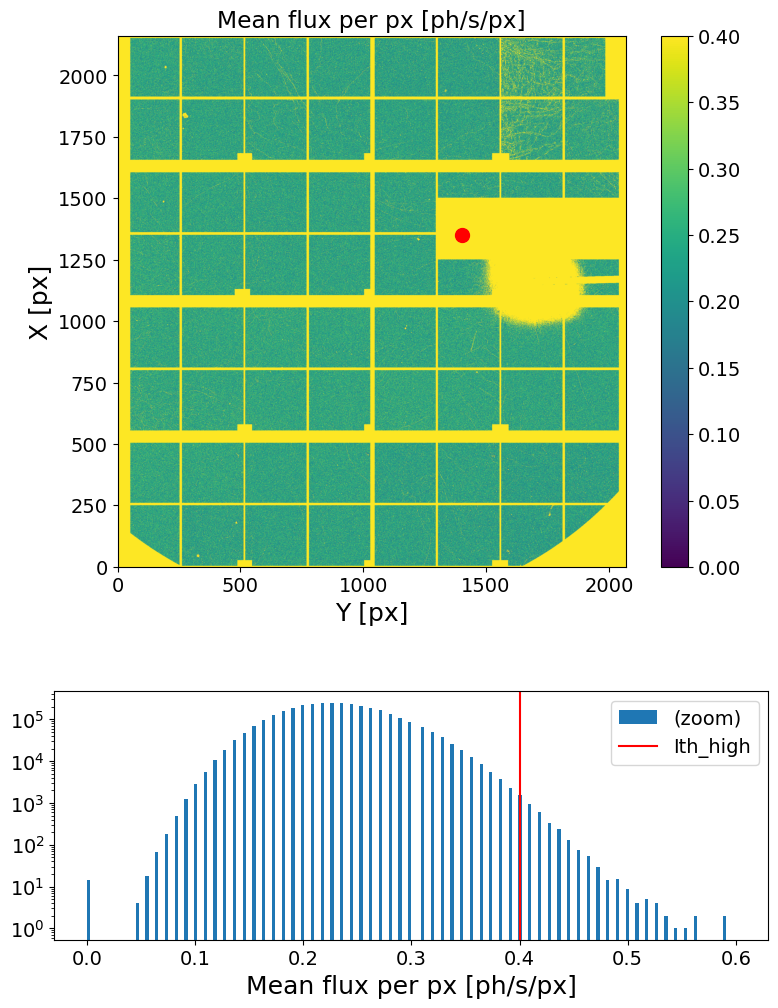

In [57]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [58]:
####################
Lbin = 1
Nstep = 1000
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

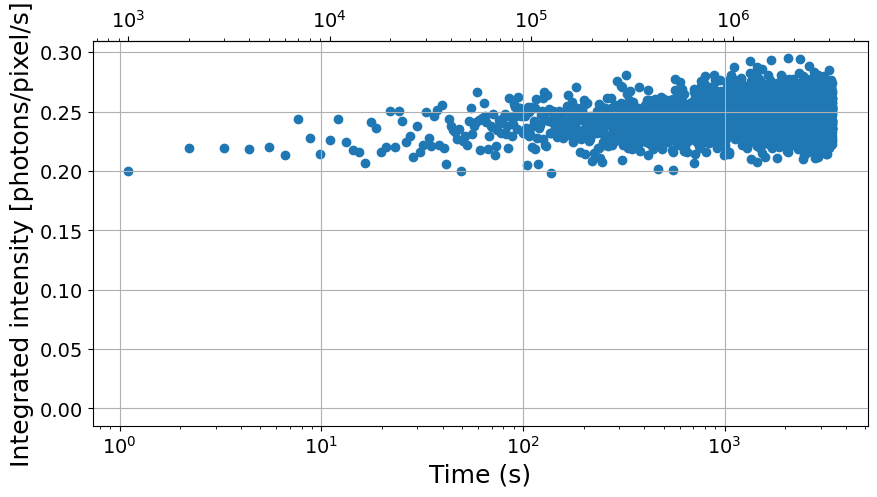

In [59]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [60]:
###################
Nfi = None
Nff = None
Lbin = 2
Nbunch = 100
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 0 , Nff = 62326 ) ...
Loading frames ...
Done! (elapsed time = 0.79 s)
	 | 62326 frames X 4471016 pixels
	 | sparsity = 2.32e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.542 GB
Masking data ...
Done! (elapsed time = 1.42 s)
	 | 62326 frames X 1424709 pixels
	 | sparsity = 2.52e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.188 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 9.37 s)
	 | 62326 X 62326 squared matrix
	 | memory usage (np.array @ float64) = 28.942 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 12.49 s)

Done!

Computing G2t for bunch 2 (Nfi = 62326 , Nff = 124652 ) ...
Loading frames ...
Done! (elapsed time = 0.41 s)
	 | 62326 frames X 4471016 pixels
	 | sparsity = 2.41e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.564 GB
Masking data ...
Done! (elapsed time = 1.66 s)
	 | 62326 frames X 1424709 pixels
	 | sparsity = 2.62e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.196 GB
Computing

KeyboardInterrupt: 

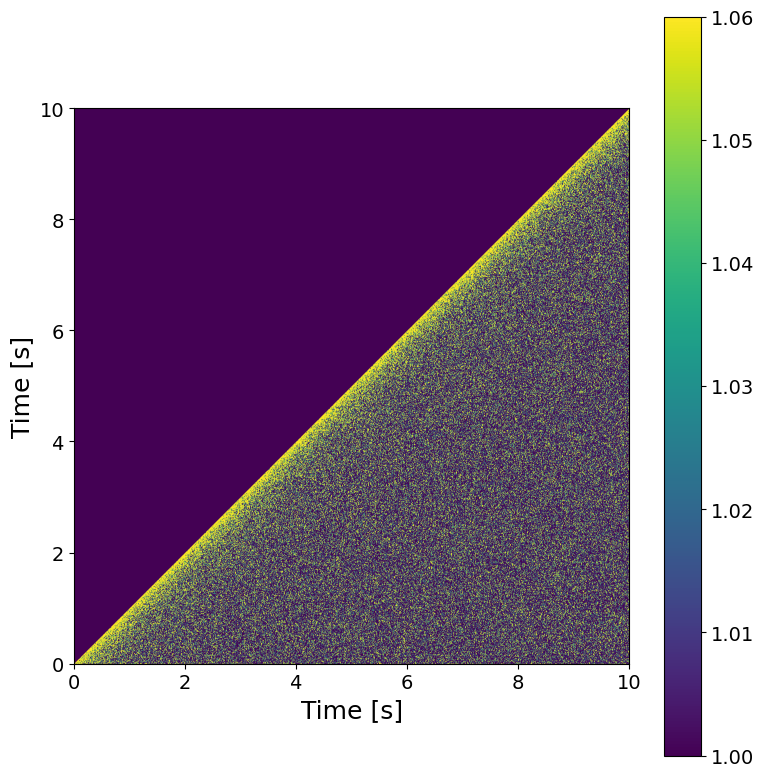

In [ ]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

In [ ]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 1.79 s)



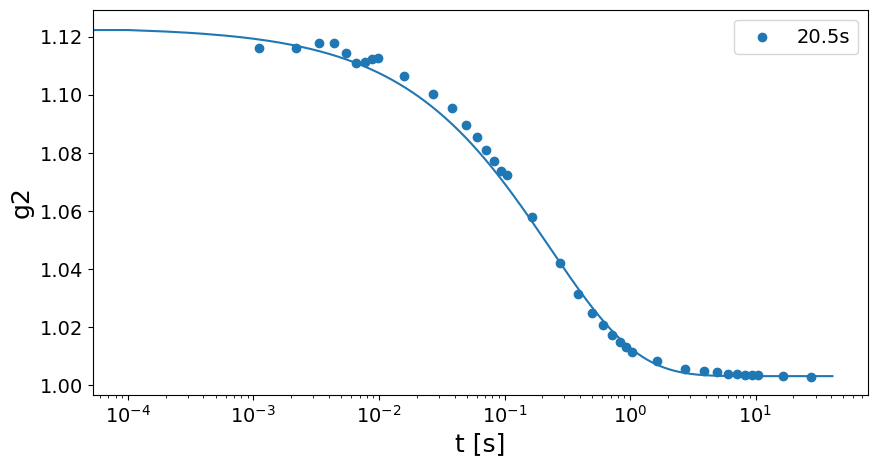

tau = 0.2299969741672385 +/- 0.010283896937404769
beta = 0.6260230763061072 +/- 0.015297183932521625
c = 0.11999999999999998 +/- 0.0027195565783599807
y0 = 1.0031999109599095 +/- 4.5141098019705e-05


In [ ]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-4)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  

## XPCS scan (T = 30C Q =  0.19 Å, 20 min @ 1ms (1_200_000 fm)) (GeO2_4_30C, dataset 2, scan 5, 10.25 keV, fresh point)

In [10]:
#######################################
sample_name = 'GeO2_4_10p25'
Ndataset = 1
Nscan = 15
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 10.25000164635837
itime = 0.0011
theta = 1.7500000000000004
Q = 0.16
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/124 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/124 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  1231 pixels (of 4471016 => 0.04 %)
################################################################################



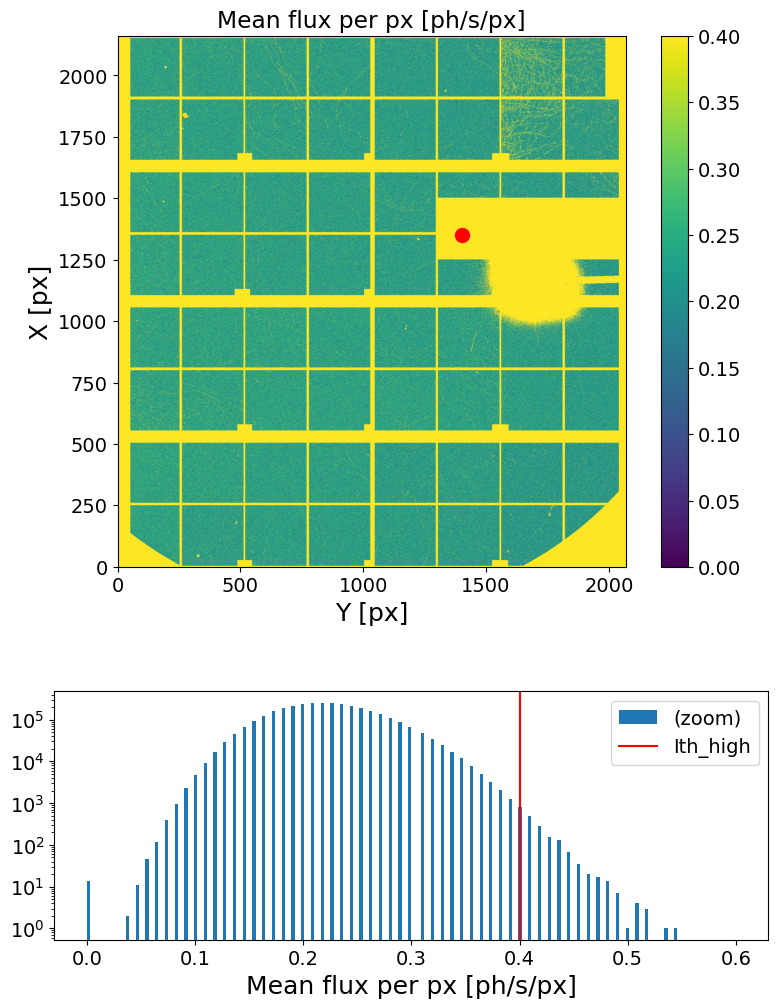

In [11]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .4, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [12]:
####################
Lbin = 1
Nstep = 10
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

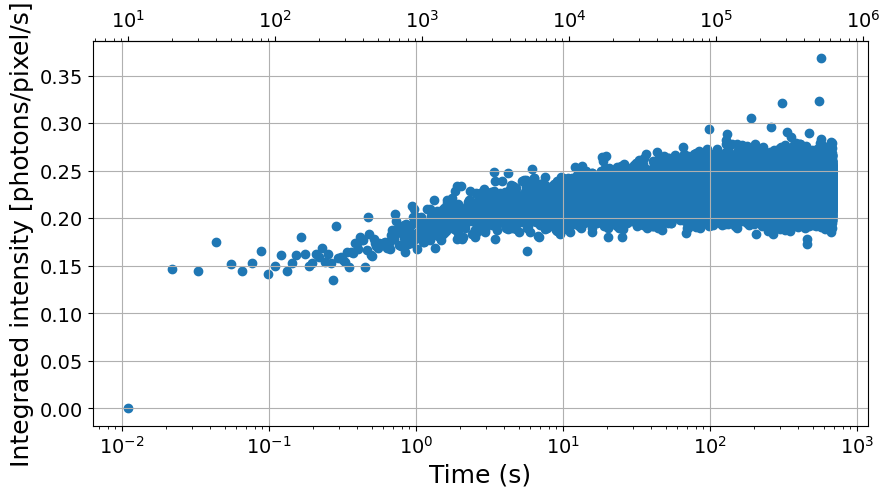

: 

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')

plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [67]:
###################
Nfi = None
Nff = None
Lbin = 1
Nbunch = 50
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t_bybunch(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, Nbunch=Nbunch)

Computing G2t for bunch 1 (Nfi = 0 , Nff = 8400 ) ...
Loading frames ...
Done! (elapsed time = 0.1 s)
	 | 8400 frames X 4471016 pixels
	 | sparsity = 2.06e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.065 GB
Masking data ...
Done! (elapsed time = 0.36 s)
	 | 8400 frames X 1424709 pixels
	 | sparsity = 2.25e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.023 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 0.16 s)
	 | 8400 X 8400 squared matrix
	 | memory usage (np.array @ float64) = 0.526 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.03 s)

Done!

Computing G2t for bunch 2 (Nfi = 8400 , Nff = 16800 ) ...
Loading frames ...
Done! (elapsed time = 0.11 s)
	 | 8400 frames X 4471016 pixels
	 | sparsity = 2.20e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.069 GB
Masking data ...
Done! (elapsed time = 0.4 s)
	 | 8400 frames X 1424709 pixels
	 | sparsity = 2.40e-04
	 | memory usage (sparse.csr_array @ uint8) = 0.024 GB
Computing G2t (using M

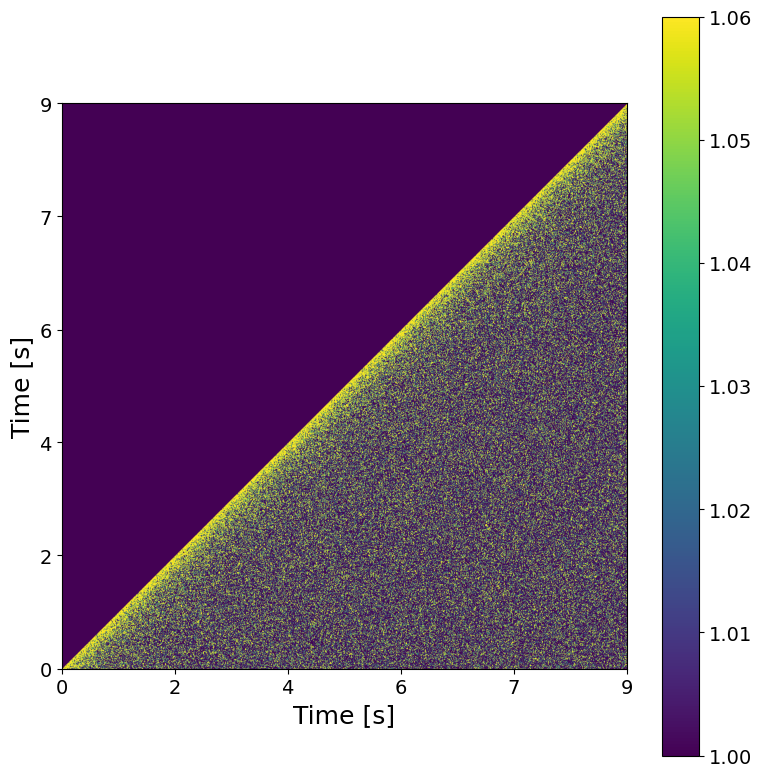

In [68]:
############################
t1, t2 = 0, 10
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime=itime, t1=t1, t2=t2, sigma_filter=3)

In [69]:
################
Nbunch = 1
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, t_mt, g2_mt = {}, {}, {}, {}
for n in range(Nbunch):
    t_bunch = round(itime*Lbin*NfXbunch*(n+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])    


Computing g2...
Done! (elapsed time = 0.12 s)



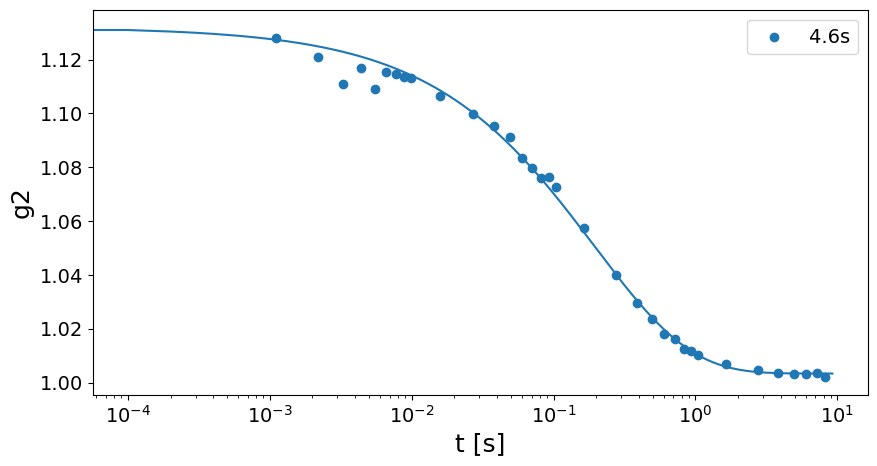

tau = 0.19416874198904283 +/- 0.014294535764219993
beta = 0.6402316931443935 +/- 0.027708796985226714
c = 0.1285937023158856 +/- 0.004946315238563381
y0 = 1.0033781346385002 +/- 0.00018049379481741267


In [70]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-4)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()

if Nbunch == 1:
    print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
    print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
    print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
    print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.show()  